In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import time


def logistic_sigmoid(a):
    return 1 / (1 + np.exp(-a))

def rand_gauss(n, mu, cov):
    if cov.ndim == 1:
        cov = np.diag(cov)
    assert(mu.ndim == 1 and len(mu) == len(cov) and cov.ndim == 2 and cov.shape[0] == cov.shape[1])
    d, v = np.linalg.eigh(cov)
    return (np.random.randn(n, len(mu)) * np.sqrt(d)).dot(v) + mu

def logpdf_gauss(x, mu, cov):
    assert(mu.ndim == 1 and len(mu) == len(cov) and (cov.ndim == 1 or cov.shape[0] == cov.shape[1]))
    x = np.atleast_2d(x) - mu
    return -0.5*(len(mu)*np.log(2 * np.pi) + np.linalg.slogdet(cov)[1] + np.sum(x.dot(np.linalg.inv(cov)) * x, axis=1))
      
def plot2dfun(f, limits, resolution, ax=None):
    if ax is None:
        ax = plt
    xmin, xmax, ymin, ymax = limits
    xlim = np.arange(ymin, ymax, (ymax - ymin) / float(resolution))
    ylim = np.arange(xmin, xmax, (xmax - xmin) / float(resolution))
    a, b = np.meshgrid(ylim, xlim)
    img = f(np.vstack([np.ravel(a), np.ravel(b)[::-1]]).T)
    img = (img - img.min()) /(img.max() - img.min()) # normalize to range 0.0 - 1.0
    img = img.reshape(a.shape+img.shape[1:])
    ax.imshow(img, cmap='gray', aspect='auto', extent=(xmin, xmax, ymin, ymax))
    plt.xlabel('$x_1$', fontsize=16)
    plt.ylabel('$x_2$', fontsize=16)

# Perceptron

$$y(\mathbf{x})=f(\mathbf{w}^T \mathbf{x})$$
where
$$f(a)=
\begin{cases}
    +1,& a\geq 0\\
    -1,& a < 0
\end{cases}$$

Při trénování procházíme trénovací vzory (např. cyklicky) a kdykoli najdeme špatně klasifikovaný vzor kde $y(\mathbf{x}_n )\ne t_n $, provedeme úpravu paramerů:

$$\mathbf{w}^{\tau+1}=\mathbf{w}^\tau+\mathbf{x}_n t_n$$

kde $\mathbf{x}_n$ je trénovací vzor a $t_n \in \{-1,1\}$ je odpovídající anotace. 


In [ ]:
red_data  = np.array([[0.2, 0.4, 0.5, 0.7, 0.9], [0.7, -0.5, 0.3, -0.9, 0.9]]).T
blue_data = np.array([[-0.1, -0.4, -0.5, -0.6, -0.7], [-0.2, 0.7, 0.6, 0.9, 0.5]]).T

plt.plot(red_data[:,0], red_data[:,1], 'r.')
plt.plot(blue_data[:,0], blue_data[:,1], 'b.')
plt.axis([-1, 1, -1, 1])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)
plt.show()

data = np.r_[red_data, blue_data]
labs = np.r_[np.ones(len(red_data)), -np.ones(len(blue_data))]

#Inicializace parametru
w = np.array([-0.1867, -0.7258])

In [ ]:
#Opakovaně zpostejte tuto buňku pro jednotlive iterace trénování

#Vykreslení rozhodovaci hranice. V našem případě nemáme parametr w_0, takže rozhodovací hranice musí procházet počatkem
plt.cla()
plt.plot(red_data[:,0],  red_data[:,1], 'r.', blue_data[:,0], blue_data[:,1], 'b.')
plt.plot([0, w[0]], [0, w[1]], 'k')
plt.plot([-w[1] * 10, w[1] * 10], [w[0] * 10, -w[0] * 10], 'k')
plt.axis([-1, 1, -1, 1])
plt.xlabel('$x_1$', fontsize=16)
plt.ylabel('$x_2$', fontsize=16)


# Najdi špatně klasifikované trénovaci dato (zelená tečka) a proveď pro nej "update".
for x, t in zip(data, labs):
  if x.dot(w) * t < 0:
    plt.plot(x[0], x[1], 'go', ms=12, lw=2)
    plt.show()
    w = w + x*t
    break

# Linearní gaussovský klasifikátor pro 2 třídy

$$\begin{align}
P(C_1|\mathbf{w}) &= \sigma(\mathbf{x}^T\mathbf{w} + w_0)\\
\mathbf{w} &= \boldsymbol{\Sigma}^{-1}(\boldsymbol{\mu}_1-\boldsymbol{\mu}_2)\\
w_0 &= -\frac{1}{2}\boldsymbol{\mu}_1^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_1
       +\frac{1}{2}\boldsymbol{\mu}_2^T\boldsymbol{\Sigma}^{-1}\boldsymbol{\mu}_2
       +\ln\frac{P(C_1)}{P(C_2)}\\
\end{align}$$
kde maximalně věrohodný odhad paramerů $\boldsymbol{\mu}_k$ je prostý průměr dat pro třídu $k$ a pro sdílenou kovarianční matici $\hat{\boldsymbol{\Sigma}}$ je to
$$%\hat{\boldsymbol{\Sigma}} = \frac{1}{N}\sum_{k=1}^K N_k\hat{\boldsymbol{\Sigma}}_k
\hat{\boldsymbol{\Sigma}} = \frac{N_1}{N_1+N_2}\hat{\boldsymbol{\Sigma}}_1+ \frac{N_2}{N_1+N_2}\hat{\boldsymbol{\Sigma}}_2,$$
kde $\hat{\boldsymbol{\Sigma}}_k$ jsou maximalně věrohodné odhady kovariančních matic pro jednotlivé třídy a $N_k$ jsou počty trénovacích vzorů pro jednolivé třídy.


In [2]:
xr = rand_gauss(1000, np.array([50, 50]), np.array([[100,  70],
                                                    [ 70, 100]]))
xb = rand_gauss(1000, np.array([40, 70]), np.array([[40,  0],
                                                    [ 0, 40]]))

hovado = rand_gauss(80, np.array([-20, 110]), np.array([[20, 0],
                                                        [ 0, 20]]))
#přidáme=li tato data, klasifikátor selže
#xb = np.r_[xb, hovado]

In [ ]:
plt.plot(xr[:,0], xr[:,1], 'r.',xb[:,0], xb[:,1], 'b.', markersize=2)
ax = plt.axis()

pCr=len(xr)/(len(xr)+len(xb))
pCb=1-pCr

cov = np.cov(xr.T)*pCr+np.cov(xb.T)*pCb
mur = np.mean(xr, axis=0)
mub = np.mean(xb, axis=0)


def Cr_posteriorV1(x): # najivni prepsani Bayesova vzorecku
    pxCr = np.exp(logpdf_gauss(x, mur, cov))*pCr # p(x,Cr)
    pxCb = np.exp(logpdf_gauss(x, mub, cov))*pCb # p(x,Cb)
    return pxCr/(pxCr+pxCb)

def Cr_posteriorV2(x): #s pouzitim logisticke sigmoidy
    logpxCr = logpdf_gauss(x, mur, cov)+np.log(pCr) # log p(x,Cr)
    logpxCb = logpdf_gauss(x, mub, cov)+np.log(pCb) # log p(x,Cb)
    return logistic_sigmoid(logpxCr-logpxCb)

def Cr_posteriorV3(x): #s pouzitim logisticke sigmoidy
    inv_cov = np.linalg.inv(cov)
    w0 = -0.5 * mur.dot(inv_cov).dot(mur) + 0.5 * mub.dot(inv_cov).dot(mub)+np.log(pCr)-np.log(pCb)
    w = inv_cov.dot(mur - mub)
    return logistic_sigmoid(x.dot(w)+ w0)
#pCr=0.5 # eventually change the prior
#pCb=1-pCr

plot2dfun(Cr_posteriorV1, ax, 500)

# Linearní gaussovský klasifikátor pro více tříd

In [ ]:
# Kód z SUR-gaussians.ipynb pro zobrazeni gaussovského klasifikatoru s vice třídami
mus  = [mur, mub, mub+[20, 0]] #Vymyslíme si nějaké střední hodnoty tříd,
covs = [cov, cov, cov+[[0,0],  #nějakou stejnou kovarianční matici pro všechny třídy
                       [0,0]]]
P = [1.0/3, 1.0/3, 1.0/3]      #a nějaké priorní pravděpodobnosti tříd.

# Funkce vrátí matici hodnot hustoty pravděpodobnosti pro jednotlivé třídy.
# Řádky odpovídaní jednotlivým pozorováním (řádkům x) a sloupce třídám.
def pdfs_for_all_classes(x):
  return np.vstack([np.exp(logpdf_gauss(x, mu, cov)) for mu, cov in zip(mus, covs)]).T

# Funkce vrátí matici posteriorních pravděpodobností pro jednotlivé třídy.
def posterior(x):
  joint_prob = pdfs_for_all_classes(x) * P
  return  joint_prob / joint_prob.sum(axis=1, keepdims=True)

# Vykreslíme hustoty pravděpodobnosti pro jednotlivé třídy.
plot2dfun(pdfs_for_all_classes, ax, 500)

# Vykreslíme posteriorní pravděpodobnosti pro jednotlivé třídy.
# Rozhodovací línie  mezi třídami budou přímky.
plt.figure()
plot2dfun(posterior, ax, 500)


# Logistická regrese - trénování pomocí metody gradientního sestupu
Nyní budeme předpokládat, že příznakový vektor $\mathbf{x}$ je rozšířen o "nultý" koeficient $x_0=1$ a parametr $w_0$ je "nultým" koeficientem vektoru $\mathbf{w}$.
$$P(C_1|\mathbf{w}) = y = \sigma(\mathbf{x}^T\mathbf{w})$$
Hledáme parametry $\mathbf{w}$, ktere minimalizují objektivní funkci - vzajemnou entropii (Cross Entropy)
$$E(\mathbf{w})=-\sum_{n=1}^N t_n\ln y_n+ (1-t_n)\ln(1-y_n)$$
kde anotace $t_n \in \{0,1\}$, $y_n = \sigma(\mathbf{x}_n^T\mathbf{w})$ a $\sigma(a)$ je logistická sigmoida. Gradient
$$\nabla E(\mathbf{w})=\sum_{n=1}^N (y_n-t_n)\mathbf{x}_n = \mathbf{X}(\mathbf{y}-\mathbf{t})$$
Pomocí metody gradientního sestupu se v kažé iteraci parametry upraví tak, že
$$\mathbf{w}^{\tau+1} =  \mathbf{w}^\tau - \eta \nabla E(\mathbf{w}^\tau)$$


In [ ]:
def x_extend(x):
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2] # kvadratická expanze
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2, x[:,0]**2*x[:,1], x[:,0]*x[:,1]**2, x**3] # kubická expanze
    return np.c_[np.ones(len(x)), x]

x = x_extend(np.r_[xr, xb]) #data rizšířime o jednicku jako "nultý" koeficient 
t = np.r_[np.ones(len(xr)), np.zeros(len(xb))]
w = np.zeros_like(x[0]) # "nultý" koeficient je w0
learning_rate = 1e-3/len(x)

xentropy=[]
for i in range(1000):
    y = logistic_sigmoid(x.dot(w))
    w = w - learning_rate * (y - t).dot(x)
    xentropy.append(np.sum(-t*np.log(y) - (1-t)*np.log(1-y)))
    if i & (i-1) == 0: # vykresli pouze iterace 0, 1, 2, 4, 8, 16, ...
      clear_output(wait=True)
      plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
      plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
      plt.show()
plt.plot(xentropy)

# Logistická regrese - Newton-Raphson
Váhy se upravují tak, že
$$\mathbf{w}^{\tau+1} =  \mathbf{w}^\tau - \mathbf{H}(\mathbf{w}^\tau)^{-1} \nabla E(\mathbf{w}^\tau)$$
kde Hessova matice (matice druhých derivací objektivní funkce $E$; anglicky Hessian)
$$\mathbf{H}(\mathbf{w})= \mathbf{XRX}^T$$

In [ ]:
# Model z předchozího kroku dotrénujeme pomoci Newton-Raphson metody, která mnohem rychleji konverguje
xentropy=[]
for i in range(10):
    y = logistic_sigmoid(x.dot(w))
    r = y * (1 - y)
    w = w - (y - t).dot(x).dot(np.linalg.inv((x.T * r).dot(x))) # Newton-Raphson update
    xentropy.append(np.sum(-t*np.log(y) - (1-t)*np.log(1-y)))

    clear_output(wait=True)
    plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
    plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
    plt.show()
plt.plot(xentropy)

# Logistická regrese - Newton-Raphson
V následující kódu opet trénujeme logistickou regresi, ale napřed data nelineárně transformujeme do vícerozměrného prostoru. Použijeme trasformaci pomoci polynomů druhého nebo třetího řádu. Navíc trénováni stabilizujeme tím, že půlíme krok pokud by uprava parametrů zhoršila objektivní funkci. Dále jsme do objektivní funkce přidali $\lambda\mathbf{w}^T\mathbf{w}$ regularizační člen, který může pomoci proti přetrénování.

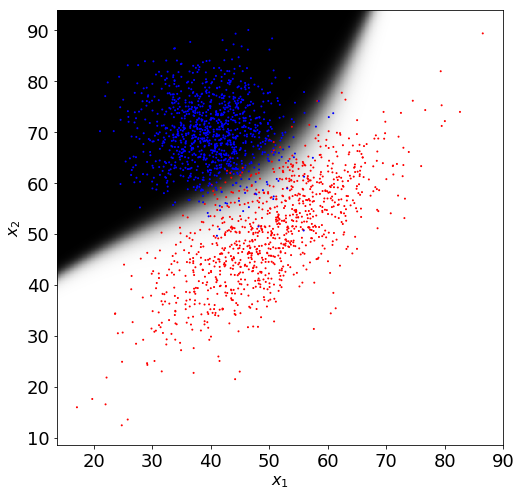

In [ ]:
def x_extend(x):
    #return np.c_[np.ones(len(x)), x]
    #return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2] # kvadratická expanze
    return np.c_[np.ones(len(x)), x, x[:,0]*x[:,1], x**2, x[:,0]**2*x[:,1], x[:,0]*x[:,1]**2, x**3] # kubická expanze

lmbd=len(x)*0.1 #Regularizacni koeficient, lmbd=0.0 => bez regularizace


x = x_extend(np.r_[xr, xb]) #data rizšířime o jednicku jako "nultý" koeficient 
t = np.r_[np.ones(len(xr)), np.zeros(len(xb))]
w = np.zeros_like(x[0]) # "nultý" koeficient je w0
y = logistic_sigmoid(x.dot(w))
xenropy_last = np.sum(-t*np.log(y) - (1-t)*np.log(1-y)) + lmbd*np.sum(w[1:]**2) 
xentropy=[xenropy_last]

#Matice s lmbd na diagonále pro regularizaci Hessianu. lmbdI[0,0]=0.0 abychom neregularizovali w_0
lmbdI = np.diag(np.r_[0, [lmbd]*len(w[1:])])
for i in range(50):
    w_old = w
    r = y * (1 - y)
    lmbdW = lmbd*np.r_[0, w[1:]] # lmbd*w, kde nultý koeficient je 0, abychom neregularizovali w0   
    w = w - ((y - t).dot(x)+lmbdW).dot(np.linalg.inv(lmbdI+(x.T * r).dot(x))) # Newton-Raphson update

    while True: # Budeme půlit krok dokud se nezlepší objectivní funkce.
      y = logistic_sigmoid(x.dot(w))
      xenropy_new = np.sum(-t*np.log(y) - (1-t)*np.log(1-y)) + lmbd*np.sum(w[1:]**2)
      if xenropy_last >= xenropy_new:
        break
      w = (w+w_old)*0.5
    xenropy_last = xenropy_new
    xentropy.append(xenropy_last)

    clear_output(wait=True)
    plt.scatter(x[:,1], x[:,2], s=1, c=t, cmap='bwr')
    plot2dfun(lambda x_: logistic_sigmoid(x_extend(x_).dot(w)), plt.axis(), 1000)
    plt.show()
plt.plot(xentropy)